In [76]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = './data/plantvillage/'
print(data_dir)

./data/plantvillage/


In [111]:
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [112]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.8, 0.1, 0.1])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 43445 | No of val: 5430 | No of test: 5430 | 


In [115]:
transform = transforms.ToTensor()
class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		if self.transform:
			return self.transform(self.dataset[index])
		else:
			return self.dataset[index]

	def __len__(self):
		return len(self.dataset)

0 is class 11
1 is class 35
2 is class 16
3 is class 35
4 is class 26
5 is class 29


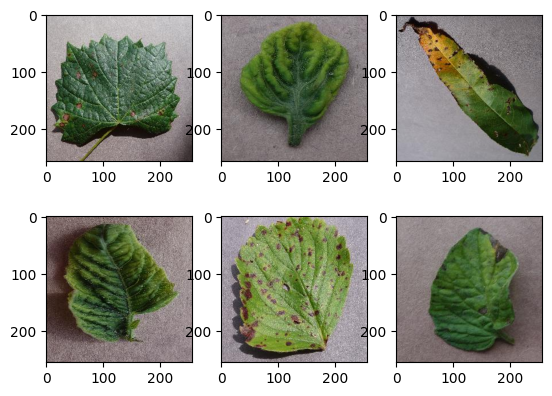

In [116]:
train_data = PlantVillageDataset(train)
val_data = PlantVillageDataset(val)
test_data = PlantVillageDataset(test)
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(train_data[i][0], cmap='grey')
    print(f'{i} is class {train_data[i][1]}')
plt.show()

In [101]:
train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)
# x, y = val_data[1]
# x,y

In [102]:
class ConvNet(nn.Module):
	def __init__(self):
		super(ConvNet, self).__init__()
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding='same')
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding='same')
		self.fc1 = nn.Linear(16*5*5, 120)   # (n + 2p -f)/s + 1
		self.fc2 = nn.Linear(120, 84)        
		self.fc3 = nn.Linear(84, 38)    
			
	def forward(self, x):
		out = self.pool(F.relu(self.conv1(x)))
		out = self.pool(F.relu(self.conv2(out)))
		out = out.view(-1, 16*5*5)
		out = F.relu(self.fc1(out))
		out = F.relu(self.fc2(out))
		out = self.fc3(out)
		return out
	
model = ConvNet().to(device)

In [103]:
#hyperparameters
n_input_size = 256*256
n_hidden_size = 10
n_classes = 38
n_epochs = 2
batch_size = 4
learning_rate = 0.001

In [104]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(summary(model, batch_dim=batch_size))

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Linear: 1-4                            48,120
├─Linear: 1-5                            10,164
├─Linear: 1-6                            3,230
Total params: 64,386
Trainable params: 64,386
Non-trainable params: 0


In [106]:
# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
losses = []
print(f'\n {"="*30}')
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        #reshape image: Flatten - 100, 1 , 28 ,28 -> 100, 748
        images = images.reshape(-1, n_input_size).to(device)
        labels = labels.to(device)
        
        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # if(epoch + 1) % 10 == 0:
    losses.append(loss.item())
    print(f'| Epoch: {epoch+1}/{n_epochs}\t| Loss: {loss.item():.4f} |')
print(f' {"="*30}\n')
end_time = time.time() - start_time
#test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_data_loader:
        images = images.reshape(-1, n_input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    accuracy = n_correct * 100.0 / n_samples
    print(f'\tAccuracy: {accuracy:.2f}%')
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')
plt.plot(losses)
plt.show()

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>